# Quantitative Finance

Zan Sadiq

---

-[Data](#data)

-[Processing](#proc)

-[Backtesting](#bt)

-[Optimization](#opt)

-[Efficient Frontier](#ef)

-[Visualization](#viz)

-[Summary](#summ)

---

In [2]:
# Install packages
import sys

In [62]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas_datareader as pdr
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import itertools
from operator import itemgetter
import tqdm

In [40]:
# Function to get pricing
def grab_dat(ticker, start, end):
    
    dat = pdr.get_data_yahoo(ticker, start, end).rename({'Adj Close': 'price'}, axis = 1)[['price']]
        
    dat['ticker'] = ticker

    # Returns
    dat['daily_pct_change'] = dat['price'] / dat['price'].shift(1) - 1
    dat['daily_pct_change'].fillna(0, inplace = True)
    dat['cum_daily_return'] = (1 + dat['daily_pct_change']).cumprod()
        
    return dat

# Function to set params
def calculate_parameters(df, n1 = None, n2 = None):
    
    if n1 is not None:
        
        df['short'] = df['price'].rolling(n1).mean()
        
    if n2 is not None:
        
        df['long'] = df['price'].rolling(n2).mean()

---

#### Data <a class="anchor" id="data"></a>

In [29]:
# Initialize list of stocks
tickers = ['AG', 
           'BABA', 
           'CSTL', 
           'HLT', 
           'IEC', 
           'PYPL', 
           'PINS', 
           'UPLD', 
           'W', 
           'MSFT', 
           'SYK', 
           'SCCO', 
           'AAPL', 
           'GOOGL', 
           'IBM', 
           'USD', 
           'GLD', 
           'TMUS', 
           'T', 
           'CHTR', 
           'CBRE', 
           'AMZN', 
           'NFLX', 
           'TSLA',
           'PGR',
           'LULU',
           'PFE',
           'DLR',
           'TXN',
           'HPE',
           'WBA',
           'MCFE',
           'JPM',
           'CCL',
           'RCL',
           'JWN',
           'CNK',
           'AMC',
           'AAL',
           'LUV']

In [30]:
# Initialize
df = pd.DataFrame()

# Get
for ticker in tickers:
    
    df = df.append(grab_dat(ticker, '2000-01-01', '2021-03-12'))

In [46]:
df.tail()

,price,ticker,daily_pct_change,cum_daily_return
Date,,,,
2021-03-05,56.919998,LUV,0.014979,5.884169
2021-03-08,60.549999,LUV,0.063774,6.259424
2021-03-09,58.930000,LUV,-0.026755,6.091955
2021-03-10,58.509998,LUV,-0.007127,6.048537
2021-03-11,58.470001,LUV,-0.000684,6.044402


*Explanation: Initially, calculations can be made using 30 and 90 day windows for short/long moving averages. Thereafter, these parameters can be optimized through iteration.*

---

#### Processing <a class="anchor" id="proc"></a>

In [43]:
df1 = pd.DataFrame()

for nm, grp in df.groupby('ticker'):
    
    calculate_parameters(grp, 30, 90)
    df1 = df1.append(grp.dropna())

In [44]:
df1.head()

,price,ticker,daily_pct_change,cum_daily_return,short,long
Date,,,,,,
2006-02-03,27.858007,AAL,-0.015328,1.531088,31.883517,28.299946
2006-02-06,27.594042,AAL,-0.009475,1.516580,31.656002,28.404381
2006-02-07,27.339500,AAL,-0.009225,1.502591,31.409946,28.493418
2006-02-08,28.272825,AAL,0.034138,1.553887,31.166719,28.595862
2006-02-09,28.612204,AAL,0.012004,1.572539,30.943290,28.693698


---

#### Backtesting <a class="anchor" id="bt"></a>

In [50]:
df2 = pd.DataFrame()

for nm, grp in df1.groupby('ticker'):
    
    try:
        
        grp['signal'] = 0
        grp['signal'][30:] = np.where(grp['short'][30:] > grp['long'][30:], 1.0, 0.0)   
        grp['positions'] = grp['signal'].diff()
    
        df2 = df2.append(grp)
        
    except:
        
        print(f'Error for {nm}..')

Error for MCFE..


In [52]:
df2.tail()

,price,ticker,daily_pct_change,cum_daily_return,short,long,signal,positions
Date,,,,,,,,
2021-03-05,47.200001,WBA,0.007256,2.337066,48.717715,43.180830,1.0,0.0
2021-03-08,48.480000,WBA,0.027119,2.400444,48.766985,43.314766,1.0,0.0
2021-03-09,48.459999,WBA,-0.000413,2.399454,48.803370,43.461641,1.0,0.0
2021-03-10,50.520000,WBA,0.042509,2.501453,48.863187,43.646741,1.0,0.0
2021-03-11,51.520000,WBA,0.019794,2.550967,48.890630,43.854591,1.0,0.0


In [56]:
portfolio = pd.DataFrame()

for nm, grp in df2.groupby('ticker'):
    
    positions = pd.DataFrame(index = grp.index).fillna(0.0)
    positions[nm] = 1000 * grp['signal'] 

    port = positions.multiply(grp['price'], axis = 0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    port['holdings'] = (positions.multiply(grp['price'], axis = 0)).sum(axis = 1)

    # Add `cash` to portfolio
    port['cash'] = 10000 - (pos_diff.multiply(grp['price'], axis = 0)).sum(axis = 1).cumsum()   

    # Add `total` to portfolio
    port['total'] = port['cash'] + port['holdings']

    # Add `returns` to portfolio
    port['returns'] = port['total'].pct_change() 
    
    port['ticker'] = nm
    
    portfolio = portfolio.append(port)

In [57]:
# Sum daily returns
agg_portfolio = portfolio.groupby(portfolio.index)['holdings', 'cash', 'total'].agg({'holdings': 'sum',
                                                                                     'cash': 'sum',
                                                                                     'total': 'sum'}, axis = 1)

---

#### Optimization <a class="anchor" id="opt"></a>

In [66]:
# Define
short_windows = [i for i in range(1, 30, 1)]
long_windows = [i for i in range(30, 60, 1)]
windows = [i for i in itertools.product(*[short_windows, long_windows])]
df3 = pd.DataFrame()

# Iterate
scores = {}

for ticker in tqdm.tqdm(tickers):
    
    score = []
    
    # Execute strategy for optimizing windows
    data = df[df['ticker'] == ticker]
    
    # Backtest windows
    for window in windows:
        
        calculate_parameters(data, window[0], window[1])
        
        # Calculate
        data['signal'] = 0
        data['signal'][window[0]:] = np.where(data['short'][window[0]:] > data['long'][window[0]:], 1.0, 0.0)   
        data['positions'] = data['signal'].diff()
        
        positions = pd.DataFrame(index = data.index).fillna(0.0)
        positions[nm] = 1000 * data['signal'] 

        port = positions.multiply(data['price'], axis = 0)
        pos_diff = positions.diff()

        port['holdings'] = (positions.multiply(data['price'], axis = 0)).sum(axis = 1)
        port['cash'] = 10000 - (pos_diff.multiply(data['price'], axis = 0)).sum(axis = 1).cumsum()   
        port['total'] = port['cash'] + port['holdings']
        
        # Update ticker
        score.append((window, port['total'].iloc[-1]))
    
    # Update master
    scores[ticker] = score
    
    # Get best
    best = max(score, key = itemgetter(1))[0] 
    
    calculate_parameters(data, best[0], best[1])
    
    data['signal'] = 0
    data['signal'][best[0]:] = np.where(data['short'][best[0]:] > data['long'][best[0]:], 1.0, 0.0)   
    data['positions'] = data['signal'].diff()
    
    df3 = df3.append(data)

100%|██████████| 40/40 [02:40<00:00,  4.01s/it]


In [68]:
portfolio1 = pd.DataFrame()

for nm, grp in df3.groupby('ticker'):
    
    positions = pd.DataFrame(index = grp.index).fillna(0.0)
    positions[nm] = 1000 * grp['signal'] 

    port = positions.multiply(grp['price'], axis = 0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    port['holdings'] = (positions.multiply(grp['price'], axis = 0)).sum(axis = 1)

    # Add `cash` to portfolio
    port['cash'] = 10000 - (pos_diff.multiply(grp['price'], axis = 0)).sum(axis = 1).cumsum()   

    # Add `total` to portfolio
    port['total'] = port['cash'] + port['holdings']

    # Add `returns` to portfolio
    port['returns'] = port['total'].pct_change() 
    
    port['ticker'] = nm
    
    portfolio1 = portfolio1.append(port)
    
# Sum daily returns
agg_portfolio1 = portfolio1.groupby(portfolio1.index)['holdings', 'cash', 'total'].agg({'holdings': 'sum',
                                                                                        'cash': 'sum',
                                                                                        'total': 'sum'}, axis = 1)

---

#### Efficient Frontier <a class="anchor" id="ef"></a>

In [84]:
'''
    Markowitz Optimization
'''    

# Gather
stocks = pd.DataFrame()

for ticker in tickers:
    
    stocks[ticker] = df[df['ticker'] == ticker]['price']

In [85]:
# Compute
logret = np.log(stocks / stocks.shift(1))
np.random.seed(100)
num_ports = 10000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

In [88]:
for x in tqdm.tqdm(range(num_ports)):
    
    # Weights
    weights = np.array(np.random.random(len(stocks.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x, :] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (logret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(logret.cov() * 252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]

100%|██████████| 10000/10000 [01:14<00:00, 133.51it/s]


In [90]:
# Get best result
best = []
   
for x, y in zip(stocks.columns, all_weights[sharpe_arr.argmax()]):

    if round(y, 2) != 0:
        
        best.append((x, y))

for b in best:

    print(f'EF Allocation for {b[0]} = {round(b[1], 2)}')    

Location of Best Allocation- 6493
EF Allocation for BABA = 0.01
EF Allocation for CSTL = 0.03
EF Allocation for HLT = 0.05
EF Allocation for IEC = 0.03
EF Allocation for PYPL = 0.03
EF Allocation for PINS = 0.03
EF Allocation for UPLD = 0.01
EF Allocation for W = 0.05
EF Allocation for SYK = 0.03
EF Allocation for SCCO = 0.05
EF Allocation for AAPL = 0.05
EF Allocation for GOOGL = 0.03
EF Allocation for IBM = 0.02
EF Allocation for USD = 0.01
EF Allocation for GLD = 0.04
EF Allocation for TMUS = 0.01
EF Allocation for T = 0.02
EF Allocation for CHTR = 0.05
EF Allocation for CBRE = 0.01
EF Allocation for AMZN = 0.04
EF Allocation for NFLX = 0.03
EF Allocation for TSLA = 0.05
EF Allocation for LULU = 0.04
EF Allocation for PFE = 0.05
EF Allocation for DLR = 0.01
EF Allocation for HPE = 0.03
EF Allocation for WBA = 0.06
EF Allocation for MCFE = 0.05
EF Allocation for JPM = 0.02
EF Allocation for CCL = 0.01
EF Allocation for RCL = 0.02
EF Allocation for CNK = 0.03
EF Allocation for AMC = 0

In [94]:
# Compute final portfolio
df4 = pd.DataFrame()
portfolio2 = pd.DataFrame()

# Iterate
for item in tqdm.tqdm(best):
    
    data = df3[df3['ticker'] == item[0]]
    
    positions = pd.DataFrame(index = data.index).fillna(0.0)
    positions[nm] = 1000 * len(tickers) * item[1] * data['signal'] 

    port = positions.multiply(data['price'], axis = 0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    port['holdings'] = (positions.multiply(data['price'], axis = 0)).sum(axis = 1)

    # Add `cash` to portfolio
    port['cash'] = 10000 - (pos_diff.multiply(data['price'], axis = 0)).sum(axis = 1).cumsum()   

    # Add `total` to portfolio
    port['total'] = port['cash'] + port['holdings']

    # Add `returns` to portfolio
    port['returns'] = port['total'].pct_change() 
    
    port['ticker'] = item[0]
    
    portfolio2 = portfolio2.append(port)
    
# Sum daily returns
agg_portfolio2 = portfolio2.groupby(portfolio2.index)['holdings', 'cash', 'total'].agg({'holdings': 'sum',
                                                                                        'cash': 'sum',
                                                                                        'total': 'sum'}, axis = 1)

100%|██████████| 34/34 [00:00<00:00, 79.57it/s]


---

#### Visualization <a class="anchor" id="viz"></a>

Text(0, 0.5, 'Cumulative Portfolio Value ($)')

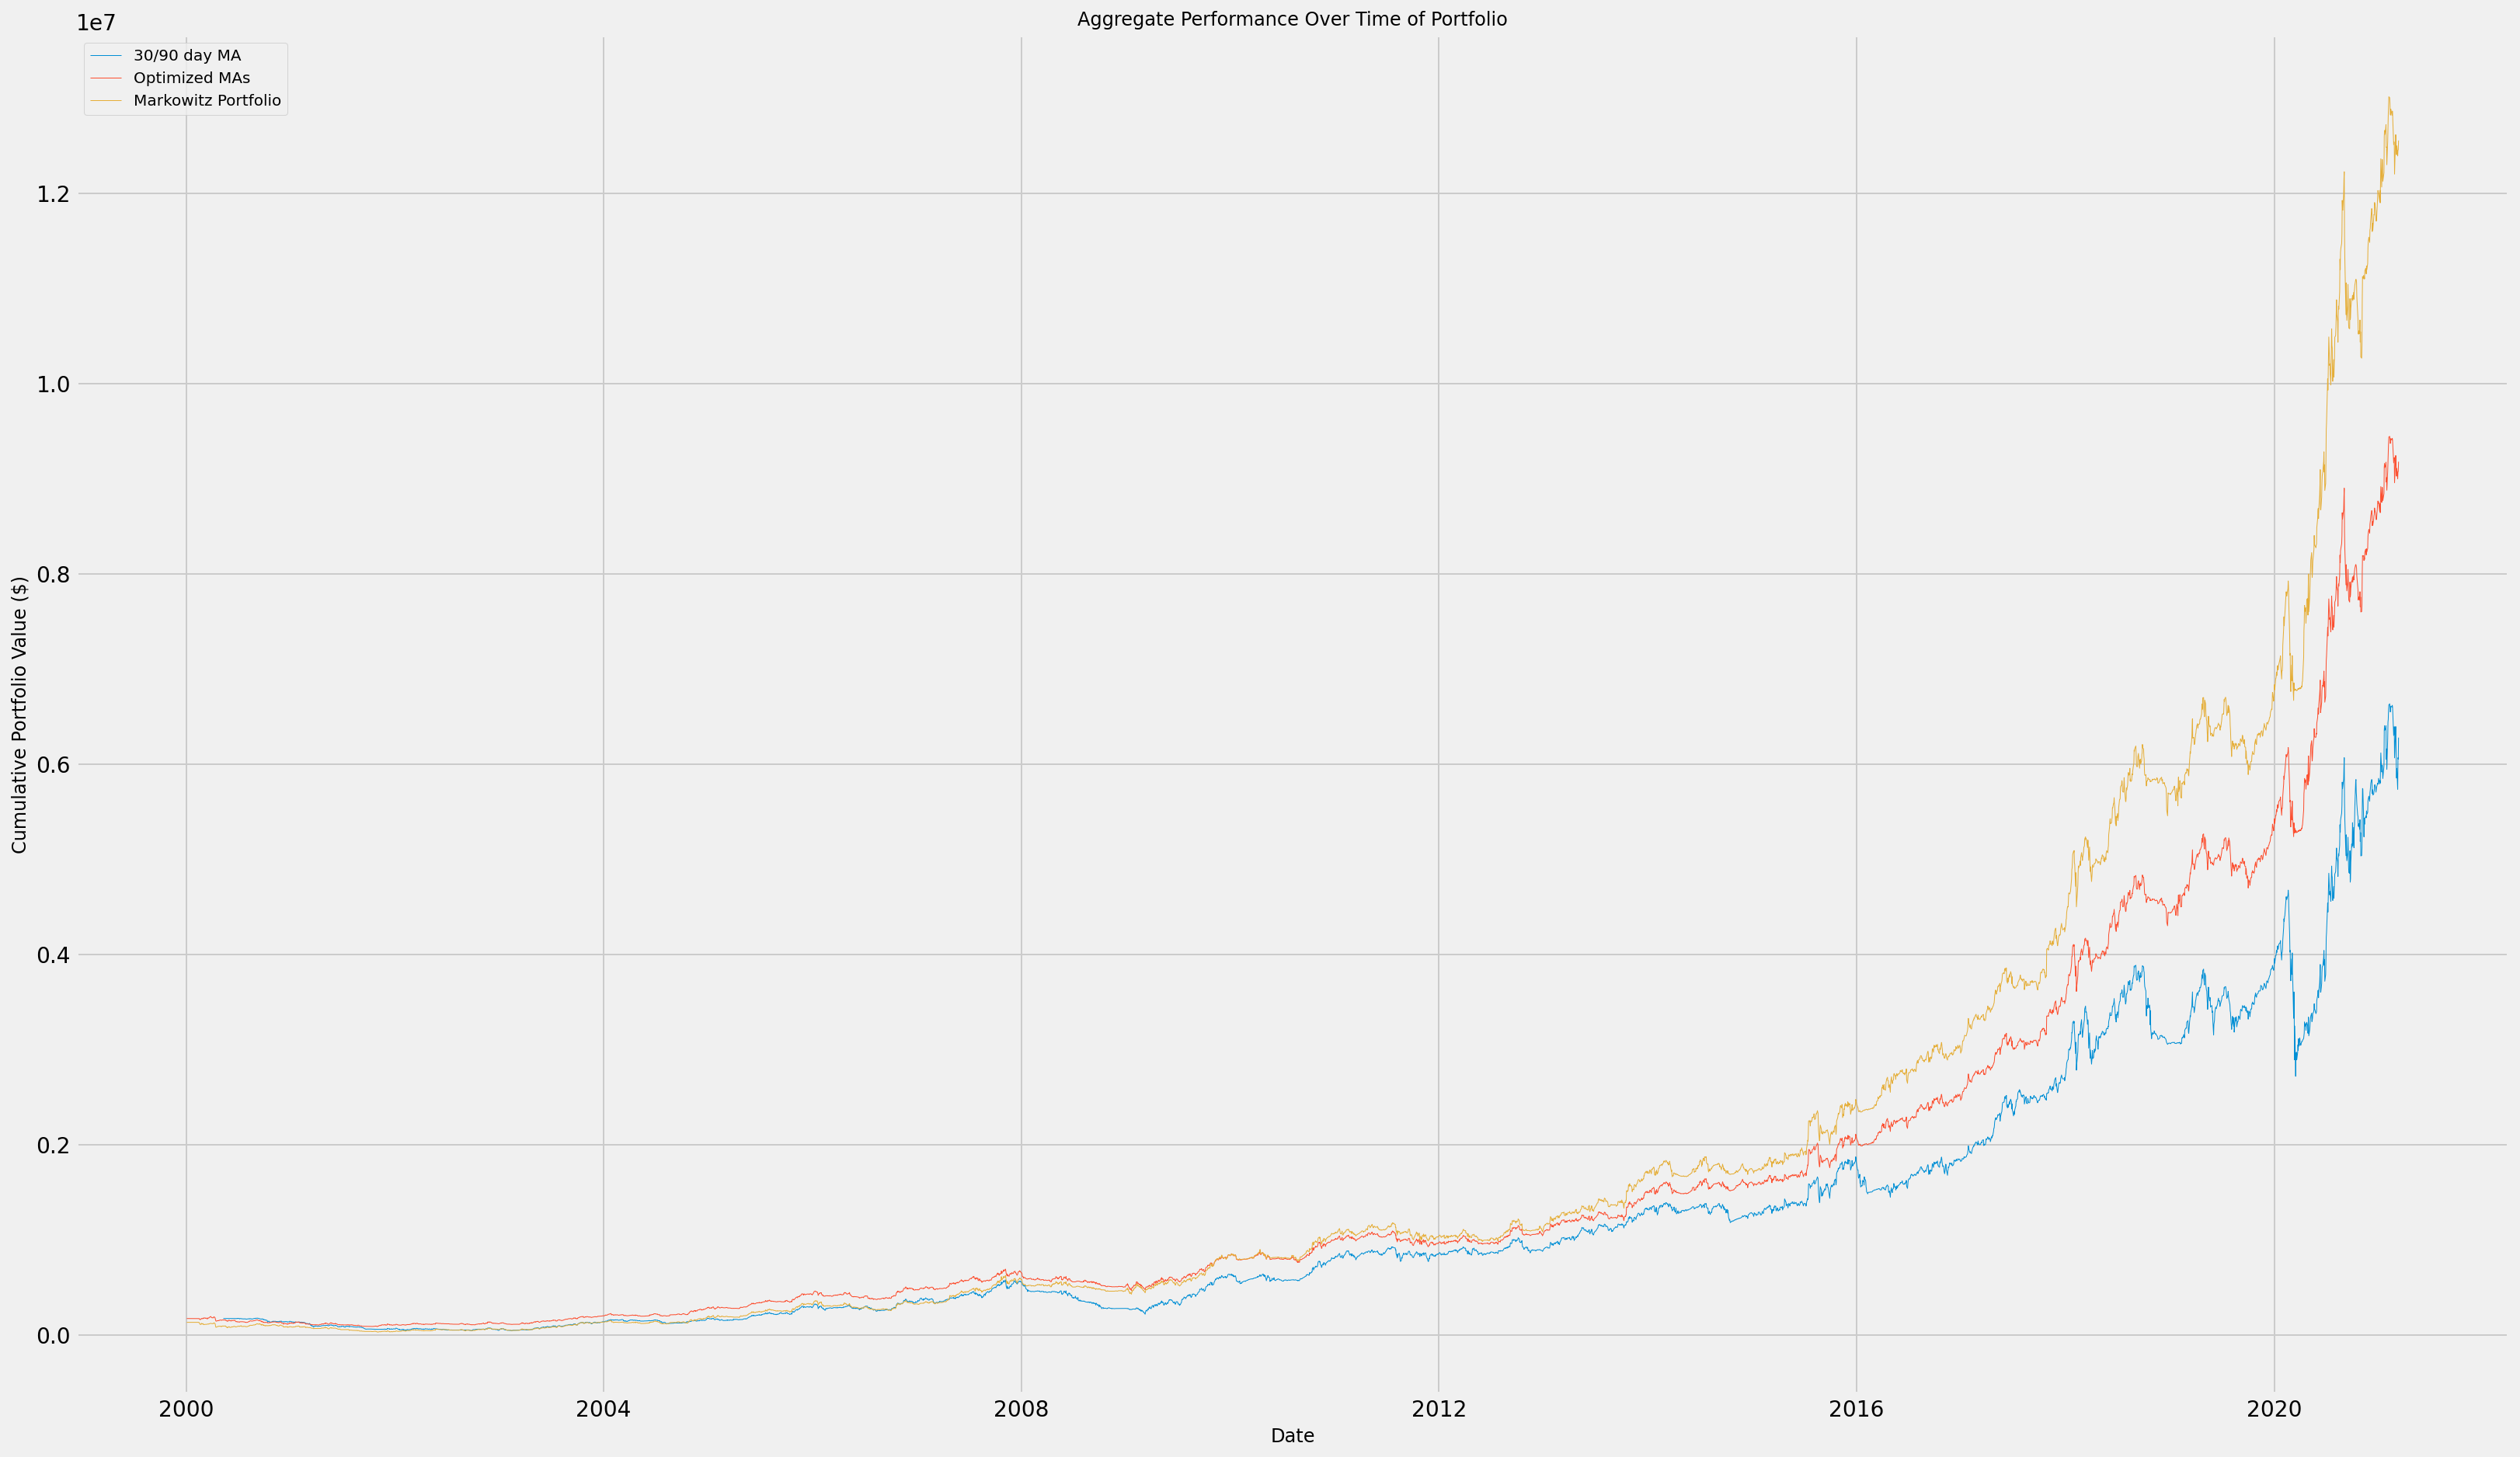

In [95]:
# Visualize performance
fig, ax = plt.subplots(figsize = (25, 15))
ax.plot(agg_portfolio['total'], lw = .5, label = '30/90 day MA')
ax.plot(agg_portfolio1['total'], lw = .5, label = 'Optimized MAs')
ax.plot(agg_portfolio2['total'], lw = .5, label = 'Markowitz Portfolio')
plt.legend(fontsize = 10)
plt.title('Aggregate Performance Over Time of Portfolio', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cumulative Portfolio Value ($)', fontsize = 12)

---

#### Summary <a class="anchor" id="summ"></a>

In [97]:
print('Overall Analysis for Portfolio:')
print(f'\n# of Stocks in Consideration- {len(tickers)}')
print(f'Total Investment = ${float(10000 * len(tickers))}')
print('\nCompanies in Ledger:\n')
print(' * '.join([ticker for ticker in tickers]))   
print(f"\nTotal Value for Portfolio w/ 30 & 60 day Moving Averages  -  ${round(agg_portfolio['total'].iloc[-1], 2)}")
print(f"Total Value for Portfolio w/ Optimized Moving Averages    -  ${round(agg_portfolio1['total'].iloc[-1], 2)}")
print(f"Total Value for Portfolio w/ Markowitz Portfolio        -  ${round(agg_portfolio2['total'].iloc[-1], 2)}")

Overall Analysis for Portfolio:

# of Stocks in Consideration- 40
Total Investment = $400000.0

Companies in Ledger:

AG * BABA * CSTL * HLT * IEC * PYPL * PINS * UPLD * W * MSFT * SYK * SCCO * AAPL * GOOGL * IBM * USD * GLD * TMUS * T * CHTR * CBRE * AMZN * NFLX * TSLA * PGR * LULU * PFE * DLR * TXN * HPE * WBA * MCFE * JPM * CCL * RCL * JWN * CNK * AMC * AAL * LUV

Total Value for Portfolio w/ 30 & 60 day Moving Averages  -  $6276394.0
Total Value for Portfolio w/ Optimized Moving Averages    -  $9176603.25
Total Value for Portfolio w/ Markowitz Portfolio        -  $12553105.28
